In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from models.EvenSmallerCNN import EvenSmallerCNN
from models.Inception import Inception
from models.ShuffleNet2 import ShuffleNet2
from models.SmallInception import SmallInception
from models.SmallerCNN import SmallerCNN
from models.SteeringCNN import SteeringCNN
from models.VGG16BasedNet import VGG16BasedNet
from utils import train_model, get_model_size

In [2]:
if torch.cuda.is_available():
    print("Using cuda")
    torch.set_default_device('cuda:0')

Using cuda


In [3]:
dataset_folder = os.path.join("put_jetbot_dataset", "dataset")
dataset_folder = "dataset"
exports_folder = "models_snapshots"
print(os.listdir(dataset_folder))

['1652875851.3497071', '1652875851.3497071.csv', '1652875901.3107166', '1652875901.3107166.csv', '1652876013.741493', '1652876013.741493.csv', '1652876206.2541456', '1652876206.2541456.csv', '1652876485.8123376', '1652876485.8123376.csv', '1652959186.4507334', '1652959186.4507334.csv', '1652959347.972946', '1652959347.972946.csv', '1653042695.4914637', '1653042695.4914637.csv', '1653042775.5213027', '1653042775.5213027.csv', '1653043202.5073502', '1653043202.5073502.csv', '1653043345.3415065', '1653043345.3415065.csv', '1653043428.8546412', '1653043428.8546412.csv', '1653043549.5187616', '1653043549.5187616.csv']


In [4]:
X = []
y = []

for file in os.listdir(dataset_folder):
    if not file.endswith(".csv"):
        continue

    dataset_name = file[:-4]

    data = pd.read_csv(os.path.join(dataset_folder, str(file)), header=None)

    for _, row in data.iterrows():
        img_id, forward, left = row
        img_path = os.path.join(dataset_folder, dataset_name, f"{int(img_id):04d}.jpg")

        X.append(img_path)
        y.append([forward, left])

X = np.array(X)
y = np.array(y, dtype=np.float32)

X.shape, y.shape

((7584,), (7584, 2))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.25)

In [6]:
class JetBotImageDataset(Dataset):
    def __init__(self, image_paths, image_ys, transform=None):
        self.image_paths = image_paths
        self.image_ys = image_ys
        self.transform = transform

        assert len(image_paths) == len(image_ys)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx])
        label = self.image_ys[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
transform = v2.Compose([
    v2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.75, 1.25)),
    v2.ToDtype(torch.float32, scale=True)
])

In [8]:
train_dataset = JetBotImageDataset(X_train, y_train, transform)
test_dataset = JetBotImageDataset(X_test, y_test, transform)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [10]:
train_features, train_labels = next(iter(test_dataloader))

In [11]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

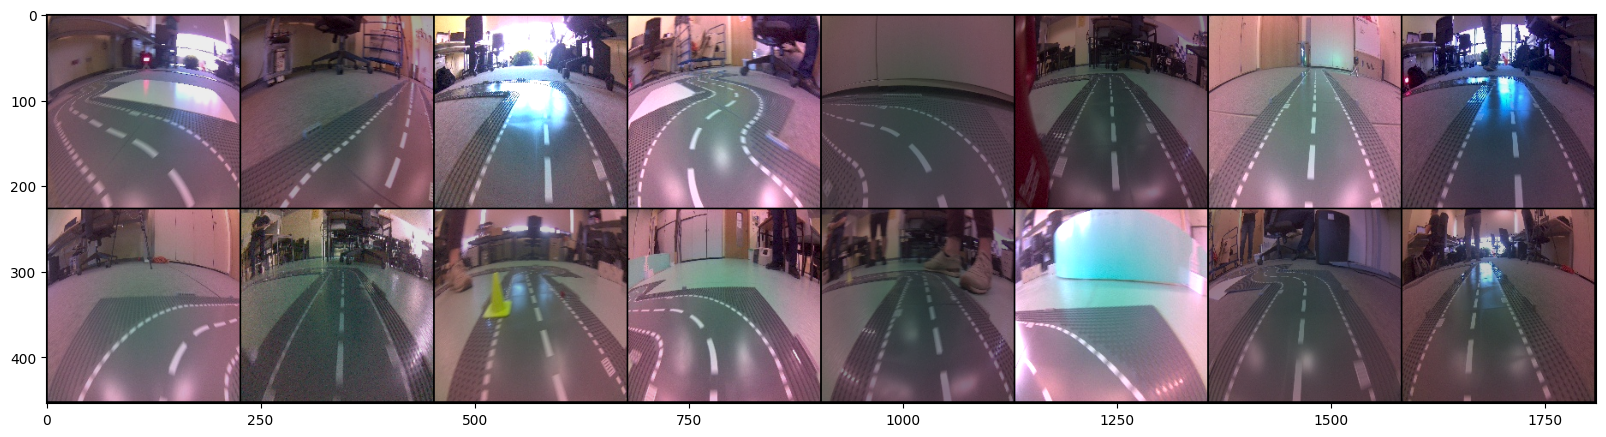

In [12]:
imshow(torchvision.utils.make_grid(train_features))

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


# SteeringCNN

In [14]:
net = SteeringCNN()
net.to(device)

SteeringCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (forward_layers): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (left_layers): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [15]:
train_model(net, 100, train_dataloader, test_dataloader, device)

EPOCH 1:
  batch 50 loss: 0.24348097488284112
  batch 100 loss: 0.21412863604724408
  batch 150 loss: 0.19740348361432553
  batch 200 loss: 0.1741552905738354
  batch 250 loss: 0.170475791990757
  batch 300 loss: 0.13154892534017562
  batch 350 loss: 0.15146130472421646
LOSS train 0.15146130472421646 valid 0.12226185947656631 learning rate 0.001
EPOCH 2:
  batch 50 loss: 0.1347741798311472
  batch 100 loss: 0.13791081003844738
  batch 150 loss: 0.12819737523794175
  batch 200 loss: 0.11479445613920689
  batch 250 loss: 0.11935738041996956
  batch 300 loss: 0.1031297805160284
  batch 350 loss: 0.1244599774479866
LOSS train 0.1244599774479866 valid 0.11226390302181244 learning rate 0.001
EPOCH 3:
  batch 50 loss: 0.10767294779419899
  batch 100 loss: 0.11944530986249446
  batch 150 loss: 0.10930834718048572
  batch 200 loss: 0.10169338062405586
  batch 250 loss: 0.1041516237705946
  batch 300 loss: 0.09136281475424766
  batch 350 loss: 0.10892241150140762
LOSS train 0.10892241150140762 v

In [16]:
get_model_size(net)

1606170

In [17]:
import torch.onnx

x = torch.randn(1, 3, 224, 224, requires_grad=True)

torch.onnx.export(net, x, os.path.join(exports_folder, 'SteeringCNN.onnx'), export_params=True, opset_version=11)

In [18]:
del net

# Smaller model proposition

In [19]:
sm_net = SmallerCNN()
sm_net.to(device)

SmallerCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=12544, out_feature

In [20]:
get_model_size(sm_net)

1195618

In [21]:
train_model(sm_net, 100, train_dataloader, test_dataloader, device)

EPOCH 1:
  batch 50 loss: 0.2567049364745617
  batch 100 loss: 0.22218371778726578
  batch 150 loss: 0.22831970646977426
  batch 200 loss: 0.239301655292511
  batch 250 loss: 0.24647481933236123
  batch 300 loss: 0.22626442551612855
  batch 350 loss: 0.2519469550251961
LOSS train 0.2519469550251961 valid 0.23177503049373627 learning rate 0.001
EPOCH 2:
  batch 50 loss: 0.23863450631499292
  batch 100 loss: 0.223060489743948
  batch 150 loss: 0.22618984147906304
  batch 200 loss: 0.2374797461926937
  batch 250 loss: 0.24380234137177467
  batch 300 loss: 0.22514143824577332
  batch 350 loss: 0.25135738879442215
LOSS train 0.25135738879442215 valid 0.23259294033050537 learning rate 0.001
EPOCH 3:
  batch 50 loss: 0.2382572530210018
  batch 100 loss: 0.22248838938772678
  batch 150 loss: 0.22625043258070945
  batch 200 loss: 0.2372253282368183
  batch 250 loss: 0.24316064149141312
  batch 300 loss: 0.22514186546206474
  batch 350 loss: 0.2514588671922684
LOSS train 0.2514588671922684 valid

In [22]:
# export as onnx with OPSET 11
x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch.onnx.export(sm_net, x, os.path.join(exports_folder, 'smaller_cnn_1p2m.onnx'), export_params=True, opset_version=11)

In [23]:
del sm_net

# Can we go even smaller?

In [24]:
model = EvenSmallerCNN()
get_model_size(model)

499922

In [25]:
train_model(model, 100, train_dataloader, test_dataloader, device)

EPOCH 1:
  batch 50 loss: 0.2627822782099247
  batch 100 loss: 0.23047351144254208
  batch 150 loss: 0.23389074727892875
  batch 200 loss: 0.24681055143475533
  batch 250 loss: 0.25008968129754067
  batch 300 loss: 0.2326356403529644
  batch 350 loss: 0.2612695980072022
LOSS train 0.2612695980072022 valid 0.23417812585830688 learning rate 0.001
EPOCH 2:
  batch 50 loss: 0.24390205964446068
  batch 100 loss: 0.22851597815752028
  batch 150 loss: 0.23418329358100892
  batch 200 loss: 0.24640825659036636
  batch 250 loss: 0.2496636714041233
  batch 300 loss: 0.23225342303514482
  batch 350 loss: 0.2616165682673454
LOSS train 0.2616165682673454 valid 0.2340957671403885 learning rate 0.001
EPOCH 3:
  batch 50 loss: 0.24396467730402946
  batch 100 loss: 0.22835711434483527
  batch 150 loss: 0.234266886562109
  batch 200 loss: 0.24638571202754975
  batch 250 loss: 0.2496271938085556
  batch 300 loss: 0.2322157582640648
  batch 350 loss: 0.261663379073143
LOSS train 0.261663379073143 valid 0.2

In [26]:
# onnx export
x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch.onnx.export(model, x, os.path.join(exports_folder, 'even_smaller_cnn_0p5m.onnx'), export_params=True, opset_version=11)

In [27]:
del model

# ShuffleNet

In [28]:
shufflenet = ShuffleNet2(net_type=0.5)
shufflenet.to(device)

ShuffleNet2(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stages): Sequential(
    (0): ShuffleBlock(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (4): 

In [29]:
get_model_size(shufflenet)

407498

In [30]:
train_model(shufflenet, 100, train_dataloader, test_dataloader, device)

EPOCH 1:
  batch 50 loss: 0.25228883549571035
  batch 100 loss: 0.22716676607728004
  batch 150 loss: 0.22736469879746438
  batch 200 loss: 0.24098826959729194
  batch 250 loss: 0.21601625472307207
  batch 300 loss: 0.15984130322933196
  batch 350 loss: 0.19185128435492516
LOSS train 0.19185128435492516 valid 0.1405816674232483 learning rate 0.001
EPOCH 2:
  batch 50 loss: 0.16084049120545388
  batch 100 loss: 0.1420902531594038
  batch 150 loss: 0.13375144131481648
  batch 200 loss: 0.14017863892018795
  batch 250 loss: 0.12250269122421742
  batch 300 loss: 0.09791339434683323
  batch 350 loss: 0.13684038393199444
LOSS train 0.13684038393199444 valid 0.11490288376808167 learning rate 0.001
EPOCH 3:
  batch 50 loss: 0.12460375286638736
  batch 100 loss: 0.11836513116955757
  batch 150 loss: 0.11631775066256524
  batch 200 loss: 0.1174989826977253
  batch 250 loss: 0.10490629799664021
  batch 300 loss: 0.08381329499185085
  batch 350 loss: 0.1281419222801924
LOSS train 0.128141922280192

In [31]:
# onnx export
x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch.onnx.export(shufflenet, x, os.path.join(exports_folder, 'shufflenet.onnx'), export_params=True, opset_version=11)

In [32]:
del shufflenet

# Inception

In [33]:
inception_net = Inception(3)
get_model_size(inception_net)

2095034

In [34]:
train_model(inception_net, 100, train_dataloader, test_dataloader, device)

EPOCH 1:
  batch 50 loss: 0.7143217194080352
  batch 100 loss: 0.7551769638061523
  batch 150 loss: 0.7028070449829101
  batch 200 loss: 0.7463696670532226
  batch 250 loss: 0.7650378036499024
  batch 300 loss: 0.7602970123291015
  batch 350 loss: 0.7171303939819336
LOSS train 0.7171303939819336 valid 0.7355663776397705 learning rate 0.001
EPOCH 2:
  batch 50 loss: 0.7219076538085938
  batch 100 loss: 0.7551769638061523
  batch 150 loss: 0.7028070449829101
  batch 200 loss: 0.7463696670532226
  batch 250 loss: 0.7650378036499024
  batch 300 loss: 0.7602970123291015
  batch 350 loss: 0.7171303939819336
LOSS train 0.7171303939819336 valid 0.7355663776397705 learning rate 0.001
EPOCH 3:
  batch 50 loss: 0.7219076538085938
  batch 100 loss: 0.7551769638061523
  batch 150 loss: 0.7028070449829101
  batch 200 loss: 0.7463696670532226
  batch 250 loss: 0.7650378036499024
  batch 300 loss: 0.7602970123291015
  batch 350 loss: 0.7171303939819336
LOSS train 0.7171303939819336 valid 0.73556637763

In [35]:
# onnx export
x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch.onnx.export(inception_net, x, os.path.join(exports_folder, 'inception.onnx'), export_params=True, opset_version=11)

In [36]:
del inception_net

# SmallInception

In [37]:
small_inception_net = SmallInception(3)
get_model_size(small_inception_net)

672370

In [38]:
train_model(small_inception_net, 100, train_dataloader, test_dataloader, device)

EPOCH 1:
  batch 50 loss: 0.21393938526511191
  batch 100 loss: 0.13595667809247972
  batch 150 loss: 0.12432900138199329
  batch 200 loss: 0.13005900882184507
  batch 250 loss: 0.11468339025974274
  batch 300 loss: 0.08721975415945053
  batch 350 loss: 0.13031308971345423
LOSS train 0.13031308971345423 valid 0.17155802249908447 learning rate 0.001
EPOCH 2:
  batch 50 loss: 0.11284506186842919
  batch 100 loss: 0.10254202246665954
  batch 150 loss: 0.10750471979379654
  batch 200 loss: 0.10312505640089512
  batch 250 loss: 0.09526801906526089
  batch 300 loss: 0.07824583016335965
  batch 350 loss: 0.11191246889531613
LOSS train 0.11191246889531613 valid 0.10420482605695724 learning rate 0.001
EPOCH 3:
  batch 50 loss: 0.095227764621377
  batch 100 loss: 0.09357270512729883
  batch 150 loss: 0.09568304050713777
  batch 200 loss: 0.09389119632542134
  batch 250 loss: 0.089200449436903
  batch 300 loss: 0.0724535296112299
  batch 350 loss: 0.10385519422590733
LOSS train 0.1038551942259073

In [39]:
# onnx export
x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch.onnx.export(small_inception_net, x, os.path.join(exports_folder, 'small_inception.onnx'), export_params=True, opset_version=11)

In [40]:
del small_inception_net